# Példa a KAN értelmezhetőségére

Erősen alapul véve a pykan könyvtár "Example 6: Solving Partial Differential Equation (PDE)" című példáját (KindXiaoming), illetve felhasználva a Liu és társai (2025) által javasolt "A toy example: how humans can interact with KANs" folyamatot

Meg szeretnénk oldani a 2D-s Poisson-egyenletet: $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, az alábbi peremfeltételekkel: $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. Az egzakt megoldás: $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

A megoldás Kolmogorov-Arnold reprezentációja (amelyet a modell közelíteni fog): $-0.5​sin(πx_1​+πx_2​+π/2)+0.5​sin(πx_1​−πx_2​+π/2)$


Először random inicializált spline-okkal elkezdjük tanítani a modellt. A loss function PDE és peremérték veszteséget tartalmaz, a súlyozás a peremértékek pontosságát részesíti előnyben.

In [2]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dim = 2
np_i = 50 # number of interior points (along each dimension)
np_b = 50 # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2,2,1], grid=5, k=3, seed=1, device=device, affine_trainable=True)


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'random' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1
    
x_i = x_i.to(device)
# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_b = x_b.to(device)

steps = 20
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

train()

cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 1.56e+00 | bc loss: 4.00e-02 | l2: 1.81e-02 : 100%|███████| 20/20 [00:49<00:00,  2.49s/it]


Ezután a modell pillanatnyi állapotát megvizsgáljuk.

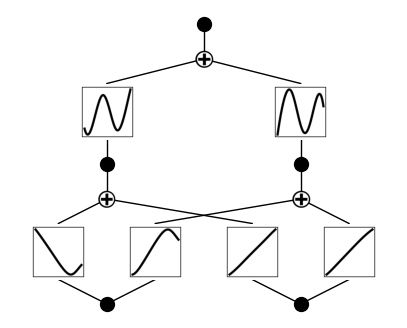

In [3]:
model.plot(beta=10)

Ha ez alapján van jó sejtésünk, hogy az egyes szinteken milyen függvények lehetnek, ezeket szimbolikusan lerögzíthetjük, azonban van lehetőség a szimbolikus függvények automatikus detektálására és rögzítésére is.

In [4]:
_ = model(x_i)

#model.auto_symbolic(r2_threshold=0.88, weight_simple=0.2)

model.fix_symbolic(0,0,0,'x', fit_params_bool=True)
model.fix_symbolic(0,0,1,'x', fit_params_bool=True)
model.fix_symbolic(0,1,0,'x', fit_params_bool=True)
model.fix_symbolic(0,1,1,'x', fit_params_bool=True)


model.fix_symbolic(1,0,0,'sin', fit_params_bool=True)
model.fix_symbolic(1,1,0,'sin', fit_params_bool=True)


r2 is 0.8681473731994629
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.1
r2 is 0.8694109916687012
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2
r2 is 0.9998122453689575
saving model version 0.3
r2 is 0.9992583394050598
saving model version 0.4
Best value at boundary.
r2 is 0.45356976985931396
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.5
Best value at boundary.
r2 is 0.5193343162536621
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.6


tensor(0.5193)

Ezután a modellt tovább tanítjuk az új aktivációs függvényekkel

In [5]:
train()

pde loss: 3.31e-11 | bc loss: 5.49e-13 | l2: 6.10e-13 : 100%|███████| 20/20 [00:23<00:00,  1.18s/it]


A modell által jósolt értékeket összevethetjük az ismert megoldással

In [7]:
from ipywidgets import interact, FloatSlider


def plot_results(x2=0.5):
    with torch.no_grad():
        t_eval = torch.linspace(-1, 1, 1000)
        t_eval_2 = x2 * torch.ones_like(t_eval)

        inputs = torch.stack([t_eval, t_eval_2], dim=1).to(device)

        # true solution u(x1,x2)=sin(pi*x1)*sin(pi*x2)
        true_sol = (torch.sin(np.pi * t_eval) * torch.sin(np.pi * t_eval_2))
        # model evaluation
        y_eval = model(inputs).cpu().numpy()

    t_eval_np = t_eval.cpu().numpy()
    true_np   = true_sol.cpu().numpy()

    plt.figure(figsize=(8,5))
    plt.plot(t_eval_np, y_eval, label="KAN")
    plt.plot(t_eval_np, true_np, '--', label="True")
    plt.legend()
    ax = plt.gca()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.show()

interact(plot_results, x2=FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.001, description="x2"))


interactive(children=(FloatSlider(value=0.5, description='x2', max=1.0, min=-1.0, step=0.001), Output()), _dom…

<function __main__.plot_results(x2=0.5)>

Ezután megvizsgálhatjuk a szimbolikus képletet, és összevethetjük az ismert megoldással: $-0.5​sin(πx_1​+πx_2​+π/2)+0.5​sin(πx_1​−πx_2​+π/2)$

In [8]:
formula = model.symbolic_formula()[0][0]
ex_round(formula,6)

0.5*sin(3.141592*x_1 - 3.141592*x_2 + 7.853981) - 0.5*sin(3.141593*x_1 + 3.141593*x_2 - 4.712389) + 1.0e-6

In [231]:
print(torch.pi/2.0)
print(3*torch.pi/2.0)
print(5*torch.pi/2.0)

1.5707963267948966
4.71238898038469
7.853981633974483


KindXiaoming, pykan: https://github.com/KindXiaoming/pykan/blob/ecde4ec3274d3bef1ad737479cf126aed38ab530/tutorials/Example/Example_6_PDE_interpretation.ipynb

Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljaˇci ́c, M., Hou, T. Y., & Tegmark, M. (2024). Kan: Kolmogorov–arnold networks. https://doi.org/10.48550/arXiv.2404.19756